# Project First Milestone Document
## WiDS Datathon 2025: Sex Patterns in ADHD


### Project Description

ADHD (Attention-Deficit/ Hyperactivity Disorder) affects approximately 15.5 million adults in the United States(CDC). While no single test can diagnose ADHD, it is typically identified through comprehensive evaluations such as medical exams, surveys, and scales. By integrating functional connectome matrics from fMRI data and categorical data, our project aims to accurately develop a statistical model that accurately classifies gender and ADHD diagnosis.




### Imports

In [272]:
# Pre-processing
import pandas as pd
import numpy as np
import openpyxl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling/classification
from sklearn import tree, svm, metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder



# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


### Data Paths

In [273]:
qm_train_data_path = "./widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx"
fcm_train_data_path = "./widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
cm_train_data_path = "./widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx"
#Sort of redundant but also useful for one part.
qm_train_data_path_old = "./widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"

y_train_path = "./widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx"



## Data Description

The data is comprised of total 2 groups of four files. The groups are pre-split in to train and test data, each containing information on 1,213 patients:

1. Target Factors: Patient sex and ADHD diagnosis status.

2. Patient characteristics, self-reported responses and parent-reported responses as recored by different questionnaires (Alabama Parenting Questionnaire and Strength and Difficulties Questionnaire) which is stored in a file called "Quantative Metadata".
(See Appendix for in-depth description of each feature)

3. Parent characteristics such as education, and occupation as well as a description of the child's ethnicity and race which is stored in a file called "Categorical Metadata."
(See Appendix for in-depth description of each feature)

4. Functional Connectome Matrices: 115 x 115 numerical matrices representing brain connectivity derived from fMRI data.

This data was obtained from Kaggle under a data science competition to build a successful predictive model.
(Where did they obtain the data? Do they say?)


Here we will be exploring the provided train data.


### Ethical Data Concerns

A key challenge in ADHD diagnosis is gender bias, with female patients often being underdiagnosed (Slobodin & Dadvidovitch, 2019). This bias could potentially influence our model which would further exacerbate the bias. Additionally, if implemented in a clinical setting, data privacy and security concerns would arise. The mishandling of data could violate HIPAA regulations putting sensitive patient mental health information at risk.


## Data preprocessing

### Loading Data

In [274]:
qm_df = pd.read_excel(qm_train_data_path)
qm_df_old = pd.read_excel(qm_train_data_path_old)
cm_df = pd.read_excel(cm_train_data_path)
connect_df = pd.read_csv(fcm_train_data_path)

y_train_absolute = pd.read_excel(y_train_path)

print(qm_df.shape)
print(connect_df.shape)
print(cm_df.shape)
print(y_train_absolute.shape)

y_train_absolute = y_train_absolute.drop(columns=['participant_id'])

(1213, 19)
(1213, 19901)
(1213, 10)
(1213, 3)


### Data Cleaning and preprocessing for fMRI Connectome dataset

The data is read into dataframes (1 for connectome data, 1 for sex/adhd outcomes)

In [275]:
combined_df = pd.concat([connect_df, y_train_absolute], axis=1)
# Drop ID column
combined_df.drop(columns=['participant_id'], inplace=True)
print(combined_df.shape)

(1213, 19902)


Now the dataframe must be split according to sex and adhd diagnosis in order to identify connectome edges with the greatest average delta

#### Sex

In [276]:
# Split dataframe by sex
sex_f = combined_df[combined_df['Sex_F'] == 1]
sex_m = combined_df[combined_df['Sex_F'] == 0]

# Calculate means for each feature
f_means = sex_f.mean()
m_means = sex_m.mean()

# Calculate difference between means and sort
sex_delta = pd.Series(abs(f_means - m_means))
sex_sorted = sex_delta.sort_values(ascending=False)
sex_hist = sex_sorted.drop(['Sex_F', 'ADHD_Outcome'])


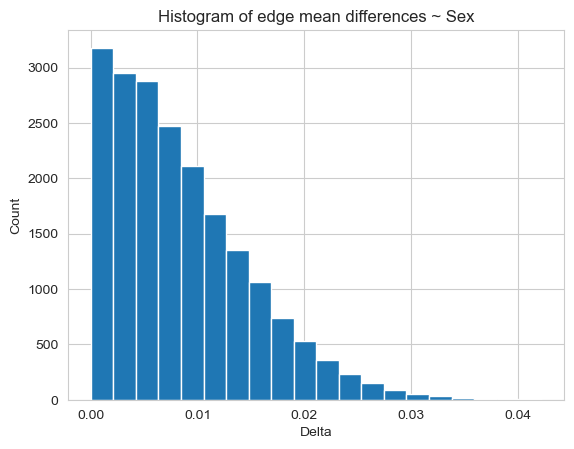

In [277]:
# Plot histogram of deltas
plt.hist(sex_hist, density=False, bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Delta')
plt.title('Histogram of edge mean differences ~ Sex')
plt.show()


In [278]:
# Top n values
sex_delta = sex_delta.drop('ADHD_Outcome')
sex_top_n = sex_delta.nlargest(n=1000, keep='all')
sex_n_edges = list(sex_top_n.index)
print(sex_n_edges)

print(combined_df.shape)
sex_train_final = combined_df.loc[:, sex_n_edges]
print(sex_train_final.shape)

['Sex_F', '28throw_35thcolumn', '70throw_80thcolumn', '133throw_173thcolumn', '56throw_60thcolumn', '138throw_173thcolumn', '67throw_177thcolumn', '53throw_83thcolumn', '39throw_142thcolumn', '2throw_163thcolumn', '30throw_67thcolumn', '35throw_130thcolumn', '126throw_130thcolumn', '29throw_77thcolumn', '30throw_77thcolumn', '83throw_188thcolumn', '28throw_34thcolumn', '90throw_188thcolumn', '126throw_163thcolumn', '141throw_166thcolumn', '102throw_163thcolumn', '134throw_175thcolumn', '142throw_156thcolumn', '56throw_166thcolumn', '80throw_181thcolumn', '152throw_164thcolumn', '58throw_66thcolumn', '44throw_156thcolumn', '34throw_64thcolumn', '72throw_173thcolumn', '28throw_126thcolumn', '104throw_181thcolumn', '3throw_102thcolumn', '28throw_189thcolumn', '67throw_165thcolumn', '12throw_163thcolumn', '83throw_87thcolumn', '93throw_173thcolumn', '75throw_171thcolumn', '30throw_38thcolumn', '47throw_84thcolumn', '83throw_177thcolumn', '149throw_198thcolumn', '37throw_165thcolumn', '146t

The processed dataframe is stored as a new .csv file for downstream use

In [279]:
# Write to new .csv file
sex_train_final.to_csv('widsdatathon2025/Processed/sex_train_final.csv', index=False)


#### ADHD

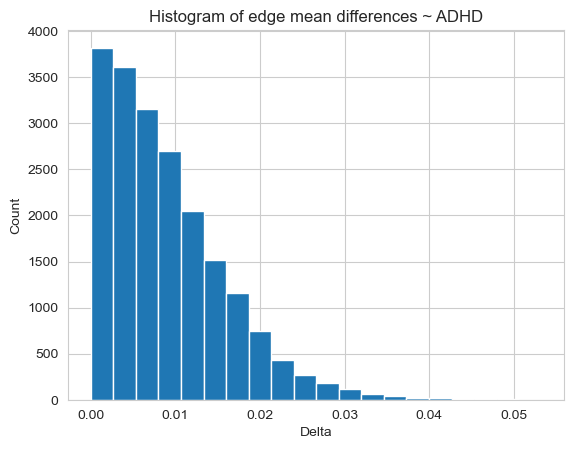

In [280]:
# Split dataframe by ADHD status
adhd_pos = combined_df[combined_df['ADHD_Outcome'] == 1]
adhd_neg = combined_df[combined_df['ADHD_Outcome'] == 0]

# Calculate means for each feature
pos_means = adhd_pos.mean()
neg_means = adhd_neg.mean()

# Calculate difference between means and sort
adhd_delta = abs(pos_means - neg_means)
adhd_sorted = adhd_delta.sort_values(ascending=False)
adhd_hist = adhd_sorted.drop(['Sex_F', 'ADHD_Outcome'])

# Plot histogram of deltas
plt.hist(adhd_hist, density=False, bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Delta')
plt.title('Histogram of edge mean differences ~ ADHD')
plt.show()


In [281]:
# Top n values
adhd_delta = adhd_delta.drop('Sex_F')
adhd_top_n = adhd_delta.nlargest(n=1000, keep='all')
adhd_n_edges = list(adhd_top_n.index)
print(adhd_n_edges)

print(combined_df.shape)
adhd_train_final = combined_df.loc[:, adhd_n_edges]
print(adhd_train_final.shape)


['ADHD_Outcome', '183throw_198thcolumn', '30throw_74thcolumn', '76throw_98thcolumn', '30throw_113thcolumn', '98throw_185thcolumn', '74throw_98thcolumn', '30throw_172thcolumn', '98throw_142thcolumn', '30throw_83thcolumn', '98throw_141thcolumn', '98throw_167thcolumn', '83throw_99thcolumn', '21throw_98thcolumn', '83throw_164thcolumn', '78throw_98thcolumn', '30throw_77thcolumn', '30throw_78thcolumn', '39throw_98thcolumn', '30throw_127thcolumn', '30throw_145thcolumn', '76throw_99thcolumn', '83throw_98thcolumn', '61throw_141thcolumn', '23throw_98thcolumn', '170throw_198thcolumn', '98throw_154thcolumn', '30throw_140thcolumn', '30throw_76thcolumn', '95throw_98thcolumn', '161throw_196thcolumn', '74throw_198thcolumn', '129throw_162thcolumn', '131throw_183thcolumn', '30throw_106thcolumn', '98throw_145thcolumn', '20throw_98thcolumn', '74throw_99thcolumn', '172throw_198thcolumn', '43throw_61thcolumn', '30throw_185thcolumn', '39throw_61thcolumn', '7throw_30thcolumn', '170throw_197thcolumn', '73throw

The processed dataframe is stored as a new .csv file for downstream use

In [282]:
# Write to new .csv file
adhd_train_final.to_csv('widsdatathon2025/Processed/adhd_train_final.csv', index=False)


### Data Cleaning and preprocessing for Quantative Metadata dataset

#### Rename Features
For easier interpretability

In [283]:
rename_dict = {"EHQ_EHQ_Total": "handedness", "ColorVision_CV_Score": "colorvision", "APQ_P_APQ_P_CP": "corporal_punishment",
               "APQ_P_APQ_P_ID": "inconsistent_discipline", "APQ_P_APQ_P_INV": "involvement", "APQ_P_APQ_P_OPD": "other_disciplines",
               "APQ_P_APQ_P_PM": "poor_monitoring", "APQ_P_APQ_P_PP": "positive_parenting",
               "SDQ_SDQ_Conduct_Problems": "conduct_problems", "SDQ_SDQ_Difficulties_Total": "total_difficulties",
               "SDQ_SDQ_Emotional_Problems": "emotional_problems",
               "SDQ_SDQ_Externalizing": "externalizing", "SDQ_SDQ_Generating_Impact": "generating_impact",
               "SDQ_SDQ_Hyperactivity": "hyperactivity", "SDQ_SDQ_Internalizing": "internalizing", "SDQ_SDQ_Peer_Problems": "peer_problems",
               "SDQ_SDQ_Prosocial": "prosocial", "MRI_Track_Age_at_Scan": "age_at_mri_scan", }
try:
    qm_df = qm_df.rename(columns=rename_dict)
    qm_df_old = qm_df_old.rename(columns=rename_dict)
except:
    print("Already renamed")

#### Intial Feature Drop

Handedness, and colorvision more than likely have nothing to do with ADHD, so we will just preemptively remove them along with participant_id.

In [284]:
if "participant_id" in y_train_absolute.columns:
    y_train = y_train_absolute.drop(columns=['participant_id'])
if "participant_id" in qm_df.columns:
    qm_df = qm_df.drop(columns=['participant_id'])
    qm_df_old = qm_df_old.drop(columns=['participant_id'])

if "handedness" in qm_df.columns:
    qm_df = qm_df.drop(columns=['handedness'])
    qm_df_old = qm_df_old.drop(columns=['handedness'])
if "colorvision" in qm_df.columns:
    qm_df = qm_df.drop(columns=['colorvision'])
    qm_df_old = qm_df_old.drop(columns=['colorvision'])


#### Initial Correlation Matrix of Features

(1213, 2)
(1213, 16)
(1213, 18)


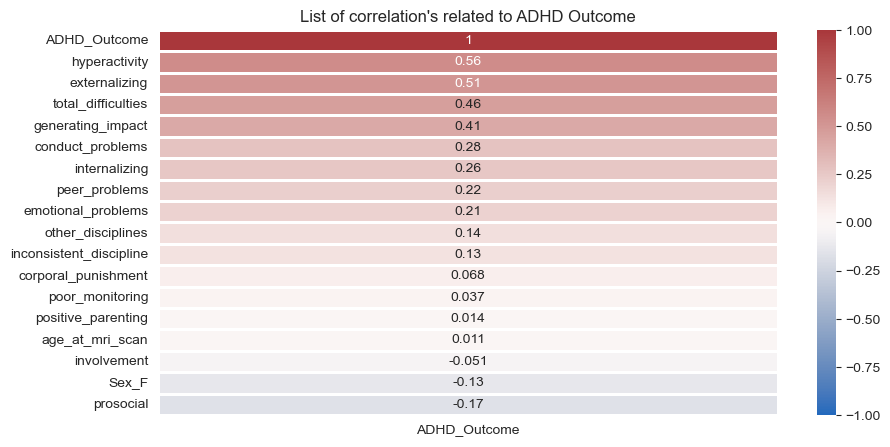

In [285]:

tempDF = pd.concat([qm_df_old, y_train_absolute], axis=1)


print(y_train_absolute.shape)
print(qm_df_old.shape)
print(tempDF.shape)

corr_matrix = tempDF.corr()

fig, ax = plt.subplots( figsize = (10, 5))
sns.set_style("whitegrid")
heat = sns.heatmap(corr_matrix[["ADHD_Outcome"]].sort_values(by='ADHD_Outcome', ascending=False), linewidth=1,annot=True, cmap = 'vlag', vmin=-1)
plt.title("List of correlation's related to ADHD Outcome")
plt.show()

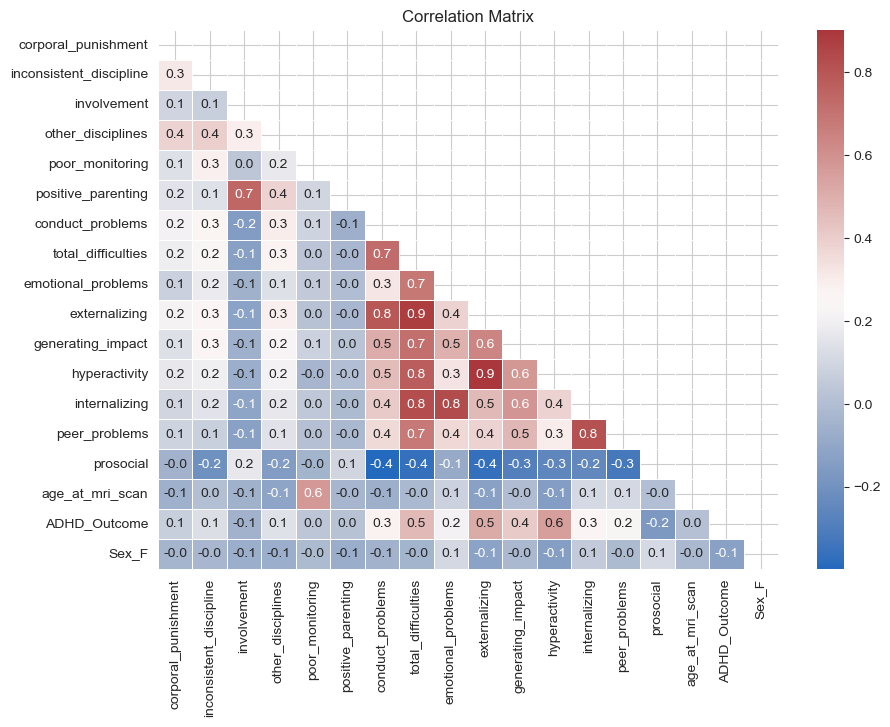

In [286]:
fig, ax = plt.subplots( figsize = (10, 7))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', fmt=".1f", linewidths= .5)
plt.title('Correlation Matrix')
plt.show()

##### Observations of correlations

Based on the second table, I believe it's reasonable to exclude these features altogether:
- positive_parenting
- involvement


Based on the first table, I believe its reasonable to consider the following features for exclusion in direct prediction of ADHD outcome
- corporal_punishment
- poor_monitoring
- positive_parenting
- age_at_mri_scan


It's important to consider features such as Internalizing and Externalizing which have high correlation with other features due to them being derived from them. (i.e. internalizing is derived from emotional problems and peer problems)

#### Feature engineering

Will skip any feature engineering for now and just remove irrelevant columns. To be improved upon later.

In [287]:
if "corporal_punishment" in qm_df.columns:
    qm_df = qm_df.drop(columns=['corporal_punishment'])
    qm_df_old = qm_df_old.drop(columns=['corporal_punishment'])
if "poor_monitoring" in qm_df.columns:
    qm_df = qm_df.drop(columns=['poor_monitoring'])
    qm_df_old = qm_df_old.drop(columns=['poor_monitoring'])
if "positive_parenting" in qm_df.columns:
    qm_df = qm_df.drop(columns=['positive_parenting'])
    qm_df_old = qm_df_old.drop(columns=['positive_parenting'])
if "age_at_mri_scan" in qm_df.columns:
    qm_df = qm_df.drop(columns=['age_at_mri_scan'])
    qm_df_old = qm_df_old.drop(columns=['age_at_mri_scan'])


#### More Feature removing based on findings

These features had no correlation with ADHD_outcome as well as no correlation with other features.

In [288]:
if "positive_parenting" in qm_df.columns:
    qm_df = qm_df.drop(columns=['positive_parenting'])
    qm_df_old = qm_df_old.drop(columns=['positive_parenting'])
if "involvement" in qm_df.columns: #Note this feature kind of depends on positive_parenting.
    qm_df = qm_df.drop(columns=['involvement'])
    qm_df_old = qm_df_old.drop(columns=['involvement'])

#### Dealing with NaN

Note from previous output, there are 21 total rows with NaN values, therefore we will drop them while maybe considering imputation for later.

In [289]:
def find_nan(df):
    print((df.isna().sum() != 0)[(df.isna().sum() != 0) == True]) #Returns columns with NaN vals
    print(df.isna().sum()[(df.isna().sum() != 0)[(df.isna().sum() != 0) == True].index]) #Returns how many NaN vals for each column
    rows_with_nan = df.index[df.isna().any(axis=1)].tolist() # find indices in dataframe
    print("Total rows with NaN values:",len(rows_with_nan))

    return rows_with_nan #returns indices of rows with NaN values used for further inspection.

In [290]:
_ = find_nan(qm_df_old)

Series([], dtype: bool)
Series([], dtype: int64)
Total rows with NaN values: 0


In [291]:
print("\nqm_df NaN values: ")
qm_rows_with_nan_indices = find_nan(qm_df)


qm_df NaN values: 
inconsistent_discipline    True
other_disciplines          True
conduct_problems           True
total_difficulties         True
emotional_problems         True
externalizing              True
generating_impact          True
hyperactivity              True
internalizing              True
peer_problems              True
prosocial                  True
dtype: bool
inconsistent_discipline    12
other_disciplines          12
conduct_problems            9
total_difficulties          9
emotional_problems          9
externalizing               9
generating_impact           9
hyperactivity               9
internalizing               9
peer_problems               9
prosocial                   9
dtype: int64
Total rows with NaN values: 21


In [292]:
print(qm_df.shape)

try:
    qm_df = qm_df.drop(qm_rows_with_nan_indices, axis=0)
    qm_df_old = qm_df_old.drop(_, axis=0)
except:
    print("Already dropped")

print(qm_df.shape)
_ = find_nan(qm_df)

(1213, 11)
(1192, 11)
Series([], dtype: bool)
Series([], dtype: int64)
Total rows with NaN values: 0


#### Dealing with Duplicates

In [293]:
print(qm_df.shape)
qm_df = qm_df.drop_duplicates()
qm_df_old = qm_df_old.drop_duplicates()
print(qm_df.shape)

(1192, 11)
(1189, 11)


#### Dealing with Outliers

Based on Interquartile Range:
<br>
We use IQR (Quartile3-Quartile1) and use that to determine upper and lower bounds for each column and remove rows based on whether there are outliers outside these bounds.

In [294]:
print(qm_df.shape)

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)] #Remove outliers not in bounds


for column in qm_df.columns:
    qm_df = remove_outliers(qm_df, column)

for column in qm_df_old.columns:
    qm_df_old = remove_outliers(qm_df_old, column)

print(qm_df.shape)


(1189, 11)
(1143, 11)


#### Normalization per each feature

We normalize each column based on whether the questionnaires has designated preset scales for there questions. See the appendix for a better understanding.
<br>

For features without preset scaling, we will be using z-score scaling. However, for exploratory interpretation, we will be defining our normalize functions but save normalization until we need to plug it into our model.
<br>

Otherwise we will just scale based on the preset scale.

In [295]:
def normalize_column(column):
    mean = column.mean()
    std = column.std()
    return (column - mean) / std


def normalize_all_quantative_columns(df):

  #For Features with no preset scale
  normalize_features = ["corporal_punishment", "inconsistent_discipline", "involvement", "other_disciplines", "poor_monitoring",
                      "positive_parenting", "internalizing", "externalizing", "generating_impact"]
  new_df = df

  for feature in normalize_features:
      if feature in new_df.columns:
          new_df[feature] = normalize_column(new_df[feature])



  # For features with preset scales
  scales = {
      'conduct_problems': (0, 10),
      'total_difficulties': (0, 40),
      'emotional_problems': (0, 10),
      'hyperactivity': (0, 10),
      'peer_problems': (0, 10),
      'prosocial': (0, 10)
  }

  #normalize with regard to its preset scale
  for feature in scales.keys():
      if feature in new_df.columns:
          new_df[feature] = (new_df[feature] - scales[feature][0]) / (scales[feature][1] - scales[feature][0])

  return new_df


#qm_df = normalize_all_quantative_columns(qm_df)

### Data Cleaning and preprocessing for Categorical Metadata dataset

Dataframe prepared

In [296]:
categorical_merged_data = pd.concat([cm_df, y_train_absolute], axis=1)

if "participant_id" in categorical_merged_data.columns:
    categorical_merged_data = categorical_merged_data.drop(columns=['participant_id'])

Checking and dealing with missing values

In [297]:
#Data processing
#missing values
missing_values = categorical_merged_data.isna().sum()
#print(missing_values)
categorical_merged_data = categorical_merged_data.fillna('3') #3 is unknown in data dictionary
print(categorical_merged_data.columns)

Index(['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'ADHD_Outcome', 'Sex_F'],
      dtype='object')


## Methods:


*   In the previous section, we conducted data pre-processing where we:
  - Cleaned Data via removing rows with missing relevant data.
  - Removed rows with outlier data according to IQR.
  - Removed features with no direct relevance in model prediction.
  - Developed a scaling method where we consider whether the data has a predetermined scale, as in Strengths and Difficulties Questionnaire (usually a scale of 1-10), otherwise we scale in relation to a normal z-score distribution for each feature. Further discretion may be in consideration for benefit of our model, taking into account, that is, which model benefits from scaling and which do not.

*   Categorical Data
  - Address the large volume of categorical data.  
  - Encoding: Perform one hot encoding on categorical variables such as race and ethnicity.


*   We have begun to scout which models may be useful for our data.
  - Some models we've begun to use against our connectome matrix are: kNN, SVM and a decision tree model
  - We will continue to consider Random Forest, kNN, SVM and even ANN models.
  - We may use clustering and PCA for continued analysis and data processing.
  - We may consider different models for our different datasets.
  - We also have to consider the classification of two outcomes, ADHD and sex.


*   Model Evaluation:
  - The Kaggle dataset is predivided into training and testing sets. Once the model is trained, a prediction is given which is then submitted to Kaggle to obtain an accuracy score.
  - We will evaluate our data across multiple models with different parameters via cross-validation of given train data. This process will split the training data into multiple folds, training the model on different data subsets thus validating it.



## Exploratory Analysis



### Exploratory analysis for the fMRI Connectome dataset

Here we explore which models may be useful in parsing the fMRI data.

#### Sex Outcome Model

In [298]:
# Read training data file and check dimensions
sex_train = pd.read_csv('widsdatathon2025/Processed/sex_train_final.csv')
print(sex_train.shape)
print(sex_train.head(5))

## Sex Section

# Create matrix for values
sex_train_X = sex_train.iloc[:, 1:1000].values

# Create matrix for outcomes
sex_train_y = sex_train.iloc[:, 0].values

(1213, 1000)
   Sex_F  28throw_35thcolumn  70throw_80thcolumn  133throw_173thcolumn  \
0      1            0.097935            0.424108              0.326014   
1      0            0.146760            0.653764             -0.029151   
2      0            0.020090            0.620638              0.221669   
3      1            0.476417            0.401553              0.041653   
4      1            0.003927            0.394467             -0.097533   

   56throw_60thcolumn  138throw_173thcolumn  67throw_177thcolumn  \
0            0.366897              0.162916             0.409607   
1            0.246368              0.095409            -0.029406   
2           -0.063529             -0.041602             0.057636   
3            0.388414             -0.079333             0.352301   
4            0.111149              0.062052             0.136079   

   53throw_83thcolumn  39throw_142thcolumn  2throw_163thcolumn  ...  \
0            0.258668             0.435321            0.059915

In [299]:
# Split data into training/testing sets, check length
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(sex_train_X, sex_train_y, random_state=1, test_size=0.8)
print(len(y_train_sex))
print(len(y_test_sex))

242
971


In [300]:
#First we will evaluate the performance of a KNN model

In [301]:
## KNN MODEL
# Train initial KNN model with k = 10
sex_KNN = KNeighborsClassifier(n_neighbors = 10)
sex_KNN.fit(X_train_sex, y_train_sex)

# Generate predictions
sex_pred_knn = sex_KNN.predict(X_test_sex)

# Evaluate model performance
print('Sex Accuracy Score:')
print(accuracy_score(y_test_sex, sex_pred_knn))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test_sex, y_pred = sex_pred_knn))

Sex Accuracy Score:
0.6580844490216272
Confusion Matrix:
[[624  19]
 [313  15]]


Accuracy: 58.8%

The KNN model shows unexpectedly poor performance. In general, the model predicts sex to be 0 (male) for most or all entries. Next we will try a SVM model.

In [302]:
## Sex Section

## SVM MODEL

# Train initial SVM model with C = 100
sex_SVM = svm.SVC(kernel='rbf', C=100)
sex_SVM.fit(X_train_sex, y_train_sex)

# Generate predictions
sex_pred_svm = sex_SVM.predict(X_test_sex)

# Evaluate model performance
print('Sex Accuracy Score:')
print(accuracy_score(y_test_sex, sex_pred_svm))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test_sex, y_pred = sex_pred_svm))

Sex Accuracy Score:
0.6807415036045315
Confusion Matrix:
[[557  86]
 [224 104]]


Accuracy: 66.7%

The SVM shows better performance than KNN, but barely. Altering the value of C has no appreciable effect.

In [303]:
## DECISION TREE MODEL

# Train initial decision tree model
sex_dtree = DecisionTreeClassifier(max_depth=10)
sex_dtree.fit(X_train_sex, y_train_sex)

# Generate predictions
sex_pred_dtree = sex_dtree.predict(X_test_sex)

# Evaluate model performance
print('Sex Accuracy Score:')
print(accuracy_score(y_test_sex, sex_pred_dtree))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test_sex, y_pred = sex_pred_dtree))


Sex Accuracy Score:
0.5870236869207003
Confusion Matrix:
[[424 219]
 [182 146]]


Accuracy: 56.4%

The decision tree mode performs worst of all, with less predictive value than simply assigning 0 to all y values. Altering max_depth and min_sample_split has no appreciable effect. We will omit the decision tree model from testing of the ADHD subset.

#### ADHD Outcome Model

In [304]:
# Read training file and check dimensions
adhd_train = pd.read_csv('widsdatathon2025/Processed/adhd_train_final.csv')
print(adhd_train.shape)
print(adhd_train.head(5))

## ADHD Section

# Create matrix for values
adhd_train_X = adhd_train.iloc[:, 1:1000].values

# Create matrix for outcomes
adhd_train_y = adhd_train.iloc[:, 0].values

(1213, 1000)
   ADHD_Outcome  183throw_198thcolumn  30throw_74thcolumn  76throw_98thcolumn  \
0             1              0.485472            0.226912            0.210598   
1             1              0.632812           -0.093353            0.315167   
2             1              0.175000           -0.153552            0.094490   
3             1              0.669601           -0.197469            0.237138   
4             1              0.495712           -0.161939            0.099471   

   30throw_113thcolumn  98throw_185thcolumn  74throw_98thcolumn  \
0            -0.386378             0.209977            0.385297   
1            -0.339005             0.163958            0.242847   
2            -0.064243            -0.104945            0.079570   
3             0.113393             0.229429            0.178904   
4             0.133711             0.025120            0.287034   

   30throw_172thcolumn  98throw_142thcolumn  30throw_83thcolumn  ...  \
0            -0.186478   

In [305]:
# Split data into training/testing sets, check length
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(adhd_train_X, adhd_train_y, random_state=1, test_size=0.8)
print(len(y_train_adhd))
print(len(y_test_adhd))

242
971


In [306]:
## KNN MODEL
# Train initial KNN model with k = 10
adhd_KNN = KNeighborsClassifier(n_neighbors = 100)
adhd_KNN.fit(X_train_adhd, y_train_adhd)

# Generate predictions
adhd_pred_knn = adhd_KNN.predict(X_test_adhd)

# Evaluate model performance
print('ADHD Accuracy Score:')
print(accuracy_score(y_test_adhd, adhd_pred_knn))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test_adhd, y_pred = adhd_pred_knn))

ADHD Accuracy Score:
0.685890834191555
Confusion Matrix:
[[  0 305]
 [  0 666]]


Accuracy: 63.8%

The KNN performs poorly as seen with the sex variable.

In [307]:
## SVM MODEL
# Train initial SVM model with C = 100
adhd_SVM = svm.SVC(kernel='rbf', C=200)
adhd_SVM.fit(X_train_adhd, y_train_adhd)

# Generate predictions
adhd_pred_svm = adhd_SVM.predict(X_test_adhd)

# Evaluate model performance
print('ADHD Accuracy Score:')
print(accuracy_score(y_test_adhd, adhd_pred_svm))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test_adhd, y_pred = adhd_pred_svm))

ADHD Accuracy Score:
0.685890834191555
Confusion Matrix:
[[ 83 222]
 [ 83 583]]


Accuracy: 70.4%

As with the sex variable, the SVM model performs better than the KNN but still has poor accuracy.

Summary

Pre-processing:

The values for the connectome data are already scaled (-1.0 to 1.0) and there is no missing data in this set.

The connectome data consists of nearly 20,000 edges as variables with 1213 total records. In order to reduce computational load, the variables were evaluated for magnitude of effect on each response factor and a subset of the most discriminatory variables (n=1000) was used for model training and prediction.

The most important edges were determined for each variable, and separate models were trained and tested for patient sex and ADHD diagnosis.

Data Modeling:

Three models were tested on the data, and none of them show promise for the final analysis. KNN consistently produced abberant results where all data points were assigned to the same category. Decision Trees performed even worse, wih less accuracy than simply assigning a single value to all predictions. SVM modeling yielded slightly better but still unsatisfactory results.

The performance of the models was largely unaffected by increasing the number of variables considered (through a range of 200-2000). Within the context of each model, the predictions were unresponsive to changes in model parameters (k, C, max_depth).

Next steps will include testing of additional models: ANN and PCA. Additionally, the two response variables (sex and ADHD status) will be combined into a single 4-factor variable and models will be tested on this combined variable.



### Exploratory analysis for the Quantative only

#### Basic stats Describing our processed, non-normalized/scaled dataset.

In [308]:
# Describe
qm_df.describe()

inconsistent_discipline  other_disciplines  conduct_problems  \
count              1143.000000        1143.000000       1143.000000   
mean                 13.319335          17.877515          1.961505   
std                   3.494610           3.177588          1.867387   
min                   5.000000          10.000000          0.000000   
25%                  11.000000          16.000000          0.000000   
50%                  13.000000          18.000000          2.000000   
75%                  16.000000          20.000000          3.000000   
max                  23.000000          26.000000          7.000000   

       total_difficulties  emotional_problems  externalizing  \
count         1143.000000         1143.000000    1143.000000   
mean            11.899388            2.227472       7.483815   
std              6.212624            2.019792       3.984586   
min              0.000000            0.000000       0.000000   
25%              7.000000            1.000000       5.000000   
50%             12.000000            2.000000       7.000000   
75%             16.000000            4.000000      10.000000   
max             29.000000            8.000000      17.000000   

       generating_impact  hyperactivity  internalizing  peer_problems  \
count        1143.000000    1143.000000    1143.000000    1143.000000   
mean            4.020997       5.522310       4.415573       2.188101   
std             2.747630       2.789017       3.304670       2.031399   
min             0.000000       0.000000       0.000000       0.000000   
25%             2.000000       4.000000       2.000000       0.000000   
50%             4.000000       6.000000       4.000000       2.000000   
75%             6.000000       8.000000       7.000000       4.000000   
max            10.000000      10.000000      14.000000       9.000000   

         prosocial  
count  1143.000000  
mean      7.768154  
std       2.080171  
min       0.000000  
25%       6.000000  
50%       8.000000  
75%      10.000000  
max      10.000000

#### Coorelation matrix

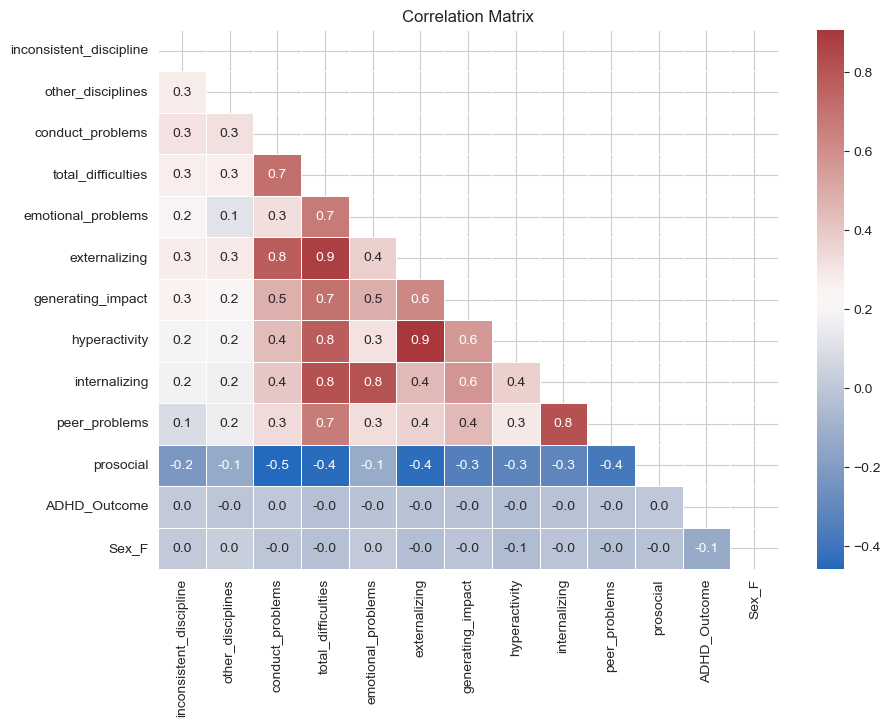

In [309]:
tempDF = pd.concat([qm_df, y_train_absolute], axis=1)
if "participant_id" in tempDF.columns:
  qm_df = qm_df.drop(columns=['participant_id'])


corr_matrix = tempDF.corr()

fig, ax = plt.subplots( figsize = (10, 7))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', fmt=".1f", linewidths= .5)
plt.title('Correlation Matrix')
plt.show()

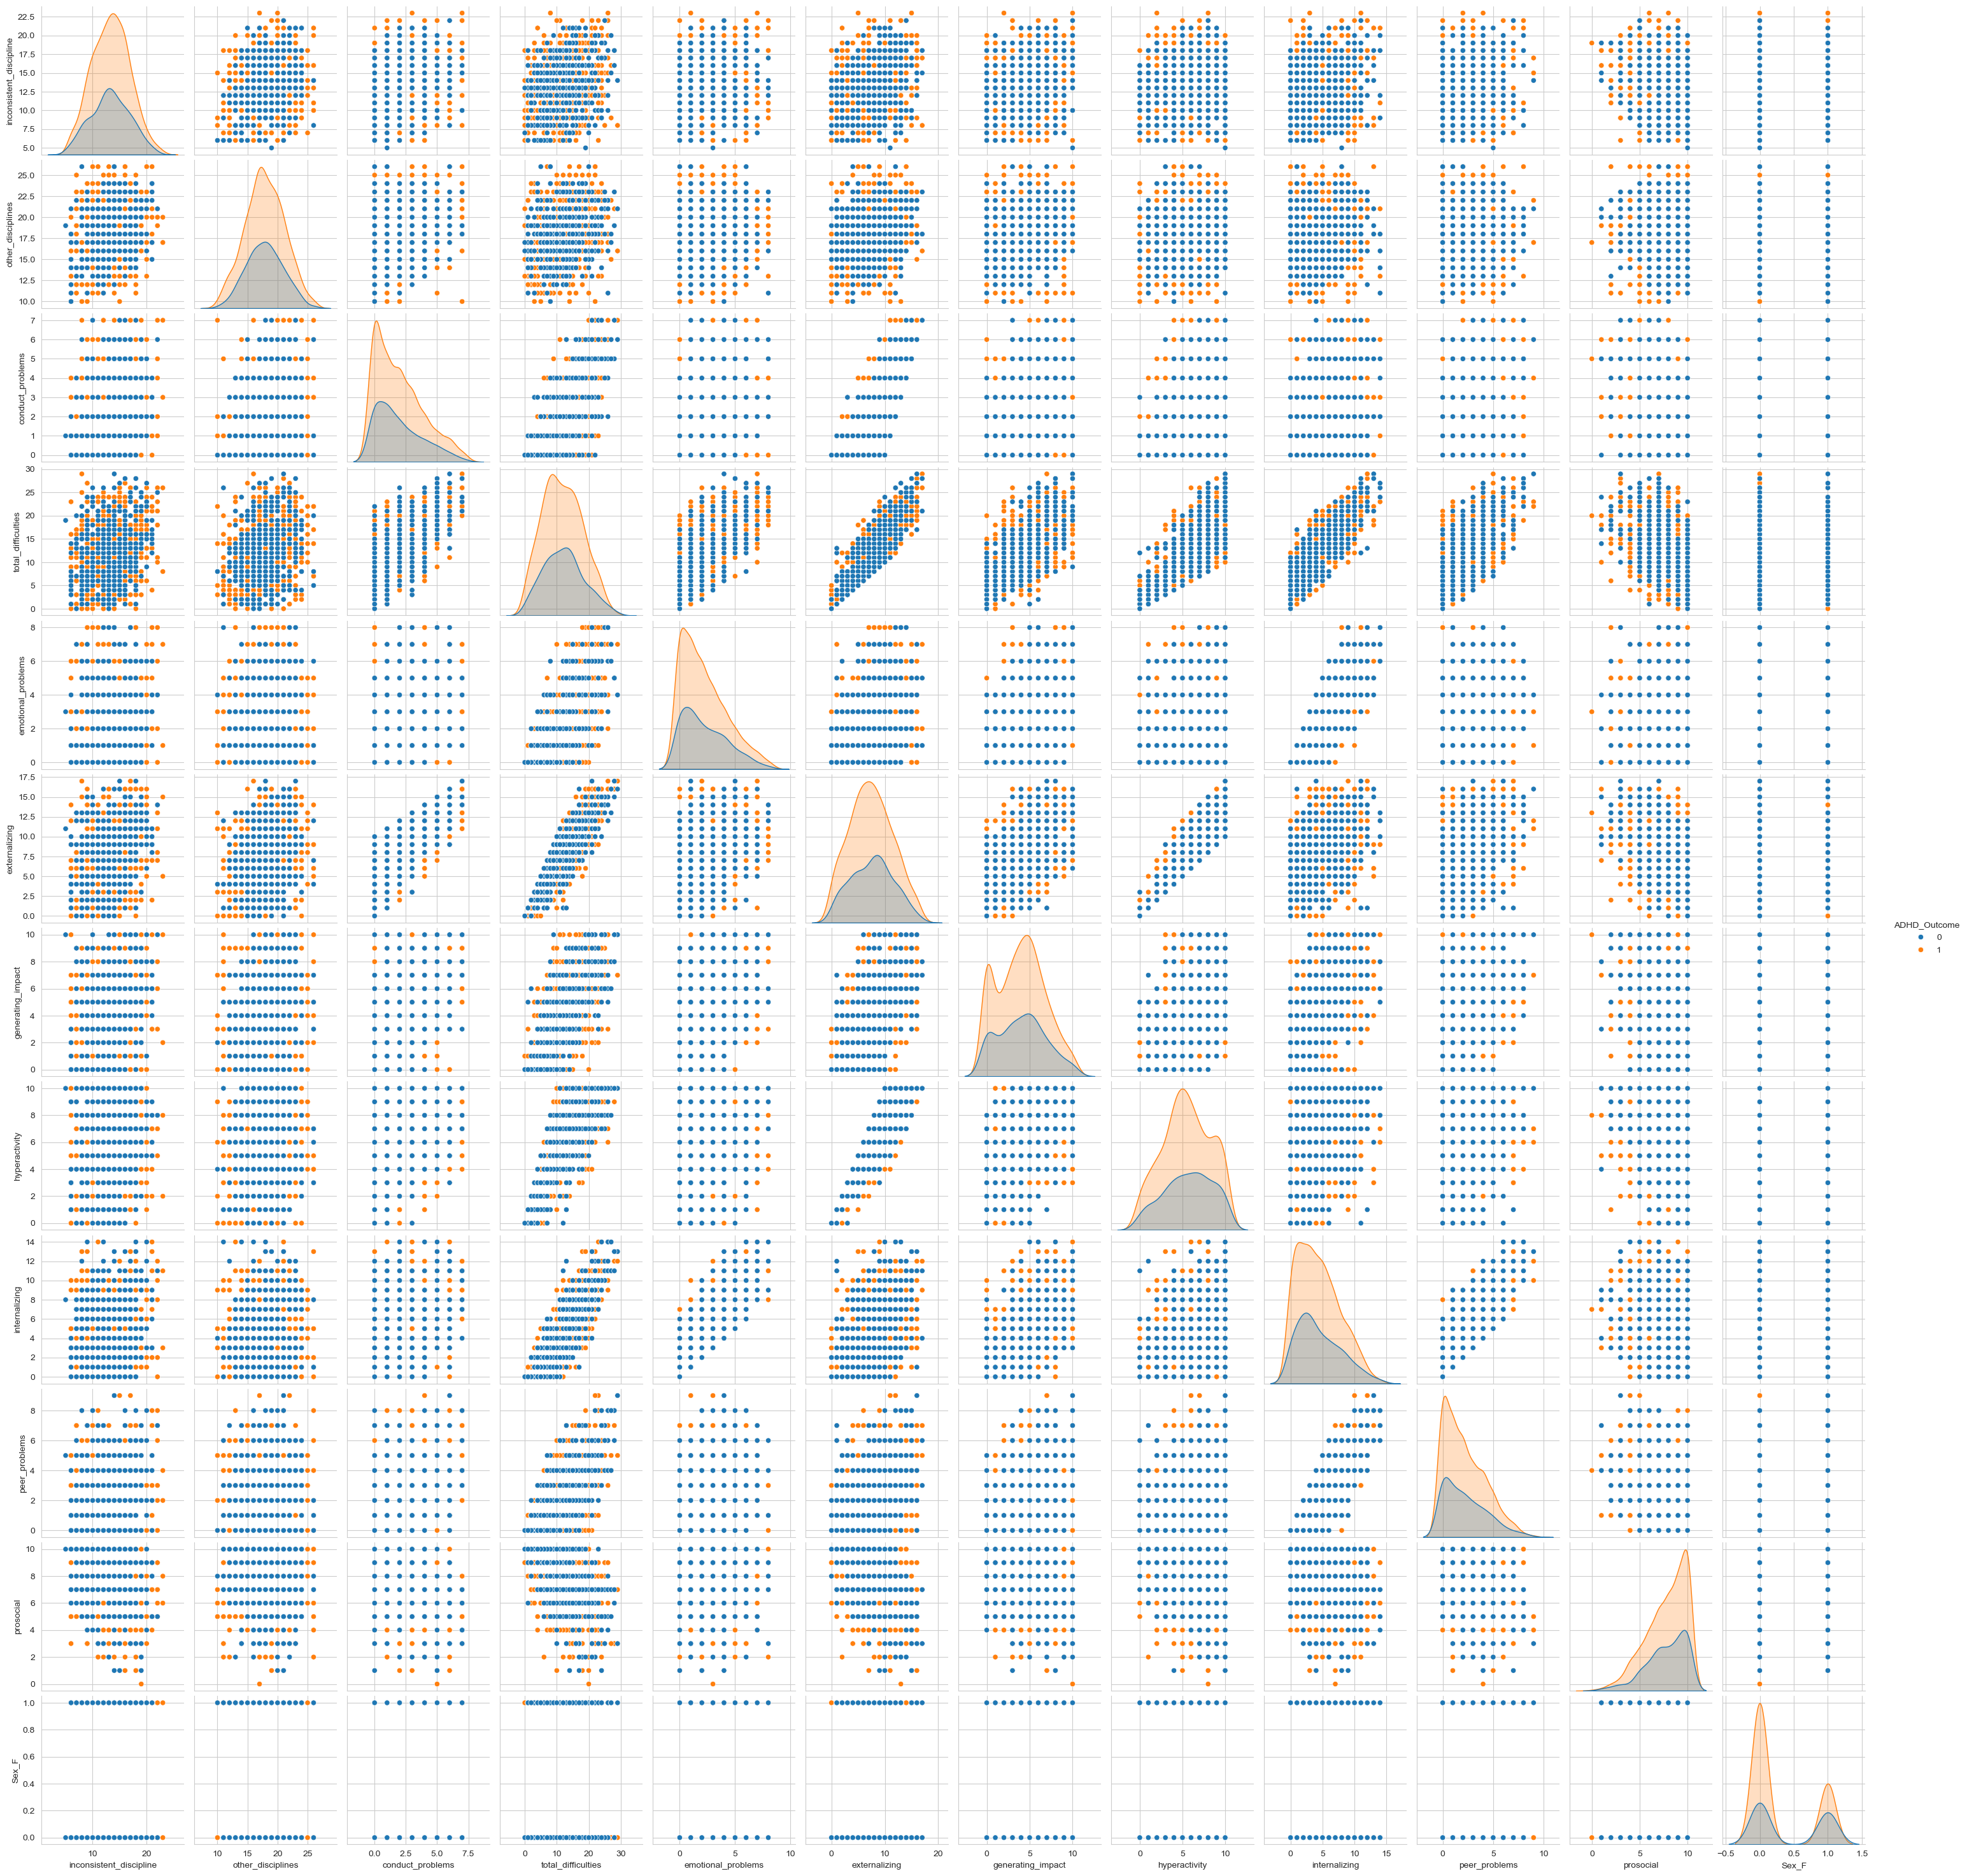

In [310]:
sns.pairplot(tempDF, hue="ADHD_Outcome")

**Observations based on above pairplot**

We can clearly begin to see patterns of ADHD_outcome clustering, usually in ring shapes. It may be useful to use PCA in attempt to separate some of the data and perform clustering.

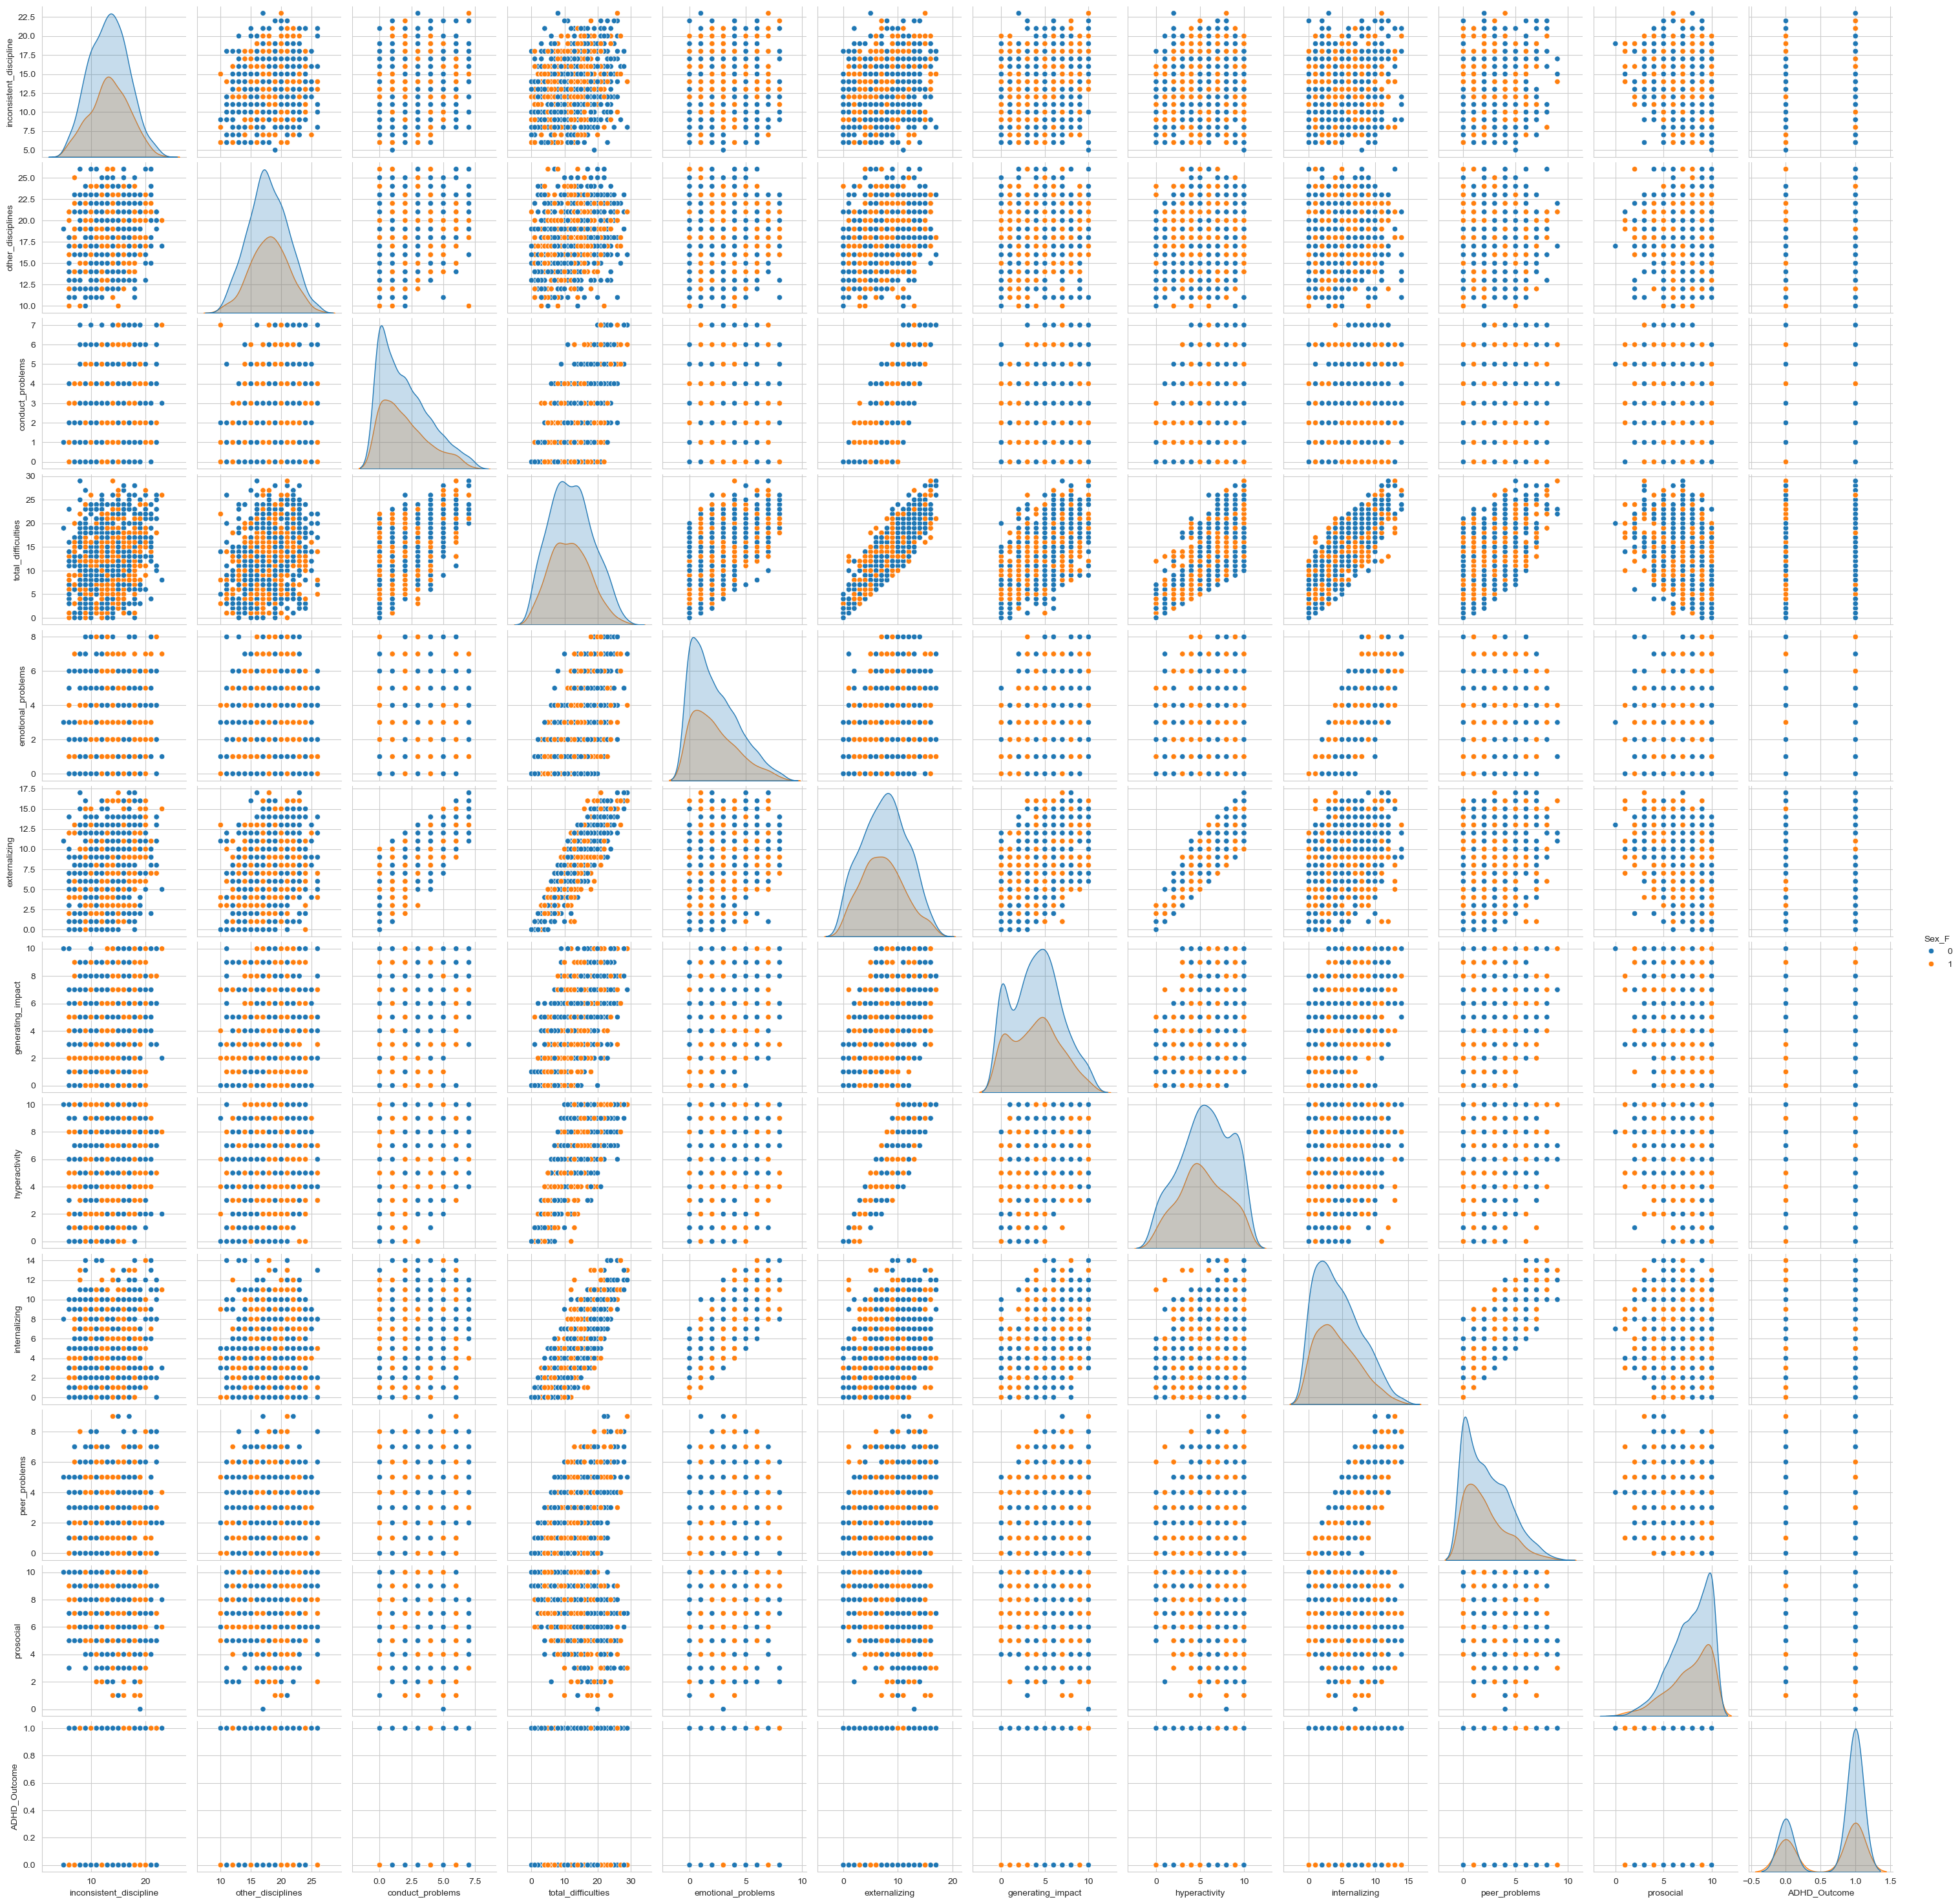

In [311]:
sns.pairplot(tempDF, hue="Sex_F")

**Observations based on above pairplot**

Here, its harder to tease out obvious clusters, indicating it will probably be a bit more difficult parsing sex from our quantative data.

### Exploratory analysis for the Categorical only

Inital Categorical Data Exploration: Race and Ethnicity Only


In [312]:
#data split into train and test
#Features selected race and ethnicity
#one hot encode race and ethnicity
X_race = pd.get_dummies(categorical_merged_data['PreInt_Demos_Fam_Child_Race'], prefix='Race')
X_ethnicity = pd.get_dummies(categorical_merged_data['PreInt_Demos_Fam_Child_Ethnicity'], prefix='Ethnicity')
X = pd.concat([X_race, X_ethnicity], axis=1)
#target ADHD diagnosis
y = categorical_merged_data[['ADHD_Outcome']].values.ravel()
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest and SVM Models


In [313]:
# random forest
#random forrest with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
#train the RF model
rf_model.fit(X_train, y_train)
#predict
y_pred_rf = rf_model.predict(X_test)

# Calculate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
#classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")
# confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")


#SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
# classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")
# confusion matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svm)}")

Accuracy: 0.5185185185185185
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.40      0.31        65
           1       0.72      0.56      0.63       178

    accuracy                           0.52       243
   macro avg       0.48      0.48      0.47       243
weighted avg       0.59      0.52      0.54       243

Confusion Matrix:
[[ 26  39]
 [ 78 100]]
Accuracy: 0.7325102880658436
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.73      1.00      0.85       178

    accuracy                           0.73       243
   macro avg       0.37      0.50      0.42       243
weighted avg       0.54      0.73      0.62       243

Confusion Matrix:
[[  0  65]
 [  0 178]]


C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross Validation of RF and SVM

In [314]:
#cross validation
svm_model = SVC(kernel='linear', random_state=42)
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"SVM Cross-Validation Scores: {cv_scores_svm}")
print(f"SVM Mean CV Score: {cv_scores_svm.mean()}")


rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Scores: {cv_scores_rf}")
print(f"Random Forest Mean CV Score: {cv_scores_rf.mean()}")

SVM Cross-Validation Scores: [0.65979381 0.67010309 0.65979381 0.64948454 0.67525773]
SVM Mean CV Score: 0.6628865979381443
Random Forest Cross-Validation Scores: [0.53092784 0.53092784 0.50515464 0.58247423 0.57216495]
Random Forest Mean CV Score: 0.5443298969072166


Analyisis of Race and Ethnicity:
When using only Race and Ethnicity to create a predictive model, the SVM model outperformed the Random Forrest Model. SVM model achieved 72.01% accuracy compared to 44.44%. To see if numbers would go up, there was an addition of two categorical varaibles added Demo site and MRI scan location. These were chosen as MRI scan location and area of study can have a significant impact on the model due to  differences in demographics, scanner technology, imaging protocols, and disease prevalence.

Additional Categorical values: Race, Ethnicity, MRI scan, and Study Site

In [315]:
#adding additional categorical variables
X_extended = categorical_merged_data [['PreInt_Demos_Fam_Child_Race',
                                       'PreInt_Demos_Fam_Child_Ethnicity',
                                       'Basic_Demos_Study_Site',
                                       'MRI_Track_Scan_Location']]

categorical_merged_data["MRI_Track_Scan_Location"] = categorical_merged_data["MRI_Track_Scan_Location"].astype(float)
#encode new categorical variables
label_encoder = LabelEncoder()
categorical_merged_data['Basic_Demos_Study_Site'] = label_encoder.fit_transform(categorical_merged_data['Basic_Demos_Study_Site'])
categorical_merged_data['MRI_Track_Scan_Location'] = label_encoder.fit_transform(categorical_merged_data['MRI_Track_Scan_Location'])

#train
X_extended = categorical_merged_data[['PreInt_Demos_Fam_Child_Race',
                                       'PreInt_Demos_Fam_Child_Ethnicity',
                                       'Basic_Demos_Study_Site',
                                       'MRI_Track_Scan_Location']]
#target
y = categorical_merged_data[['ADHD_Outcome']].values.ravel()
#split
X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.2, random_state=42)

RF and SVM Models

In [316]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")

# SVM
svm_model = SVC(kernel='linear', random_state=42)
# Train the model
svm_model.fit(X_train, y_train)
# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")


Random Forest Accuracy: 0.6954732510288066
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.12      0.18        65
           1       0.74      0.90      0.81       178

    accuracy                           0.70       243
   macro avg       0.53      0.51      0.50       243
weighted avg       0.63      0.70      0.64       243

SVM Accuracy: 0.7325102880658436
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.73      1.00      0.85       178

    accuracy                           0.73       243
   macro avg       0.37      0.50      0.42       243
weighted avg       0.54      0.73      0.62       243



C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\patri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross Validation

In [317]:
# Perform cross-validation
rf_cv_score = cross_val_score(rf_model, X_extended, y, cv=5)
svm_cv_score = cross_val_score(svm_model, X_extended, y, cv=5)

print(f"Random Forest Mean CV Score: {rf_cv_score.mean()}")
print(f"SVM Mean CV Score: {svm_cv_score.mean()}")

Random Forest Mean CV Score: 0.6776621433187089
SVM Mean CV Score: 0.6850797537666224


Additional categorical values improved both models significantly, with Random Forrest increasing to 72.8% and SVM reaching 73.8%. This suggests adding more categorical information will further enhance the model.

 The same could be said for the Cross Validation. When all categorical variables were used, the RF Mean CV Score increased to 0.6637 and the SVM Mean CV Score to 0.6851, indicating better generalization. However, when only race/ethnicity was included, the SVM Mean CV Score dropped to 0.6711, and the RF Mean CV Score significantly decreased to 0.4794

### Combining Categorical and Quantative datasets

In [318]:
#drop rows from x_extended that are left in qm_df
Z_extended = X_extended[X_extended.index.isin(qm_df_old.index)]


X_train_cmqm = pd.concat([qm_df_old, Z_extended], axis=1)

In [319]:
X_train_cmqm.describe()

inconsistent_discipline  other_disciplines  conduct_problems  \
count              1152.000000        1152.000000       1152.000000   
mean                 13.323785          17.889757          1.946181   
std                   3.502541           3.178036          1.868078   
min                   5.000000          10.000000          0.000000   
25%                  11.000000          16.000000          0.000000   
50%                  13.000000          18.000000          2.000000   
75%                  16.000000          20.000000          3.000000   
max                  23.000000          26.000000          7.000000   

       total_difficulties  emotional_problems  externalizing  \
count         1152.000000         1152.000000    1152.000000   
mean            11.806424            2.210069       7.425347   
std              6.276418            2.021424       4.023344   
min              0.000000            0.000000       0.000000   
25%              7.000000            1.000000       4.000000   
50%             12.000000            2.000000       7.000000   
75%             16.000000            4.000000      10.000000   
max             29.000000            8.000000      17.000000   

       generating_impact  hyperactivity  internalizing  peer_problems  \
count        1152.000000    1152.000000    1152.000000    1152.000000   
mean            3.989583       5.479167       4.381076       2.171007   
std             2.759688       2.820352       3.314621       2.032600   
min             0.000000       0.000000       0.000000       0.000000   
25%             2.000000       4.000000       2.000000       0.000000   
50%             4.000000       5.000000       4.000000       2.000000   
75%             6.000000       8.000000       7.000000       4.000000   
max            10.000000      10.000000      14.000000       9.000000   

         prosocial  Basic_Demos_Study_Site  MRI_Track_Scan_Location  
count  1152.000000             1152.000000              1152.000000  
mean      7.707465                1.011285                 1.292535  
std       2.182072                1.135806                 0.750566  
min       0.000000                0.000000                 0.000000  
25%       6.000000                0.000000                 1.000000  
50%       8.000000                0.000000                 1.000000  
75%      10.000000                2.000000                 2.000000  
max      10.000000                3.000000                 3.000000

#### Single correlation matrix for ADHD outcome

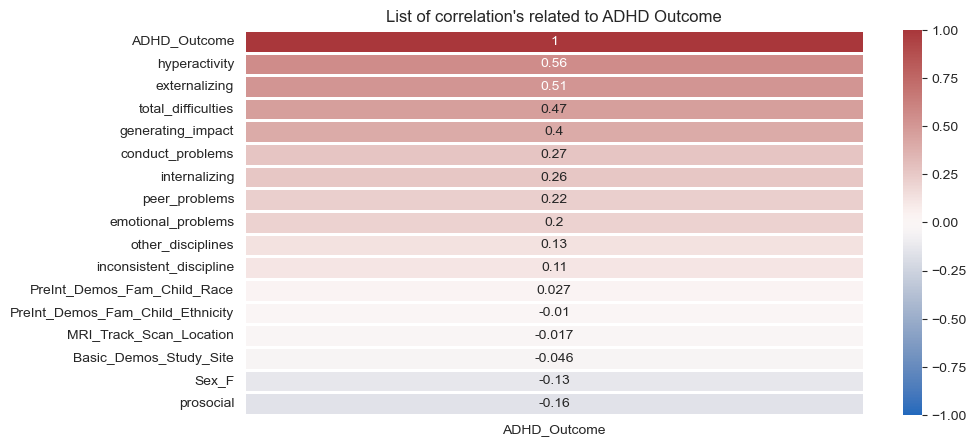

In [320]:
tempDF = pd.concat([X_train_cmqm, y_train_absolute], axis=1)
if "participant_id" in tempDF.columns:
    qm_df = qm_df.drop(columns=['participant_id'])

corr_matrix = tempDF.corr()

fig, ax = plt.subplots( figsize = (10, 5))
sns.set_style("whitegrid")
heat = sns.heatmap(corr_matrix[["ADHD_Outcome"]].sort_values(by='ADHD_Outcome', ascending=False), linewidth=1,annot=True, cmap = 'vlag', vmin=-1)
plt.title("List of correlation's related to ADHD Outcome")
plt.show()

**Observations**
<br>

Here we can see that there exists only a tiny bit of correlative power with ADHD and our categorical variables.


#### Single correlation matrix for Sex outcome

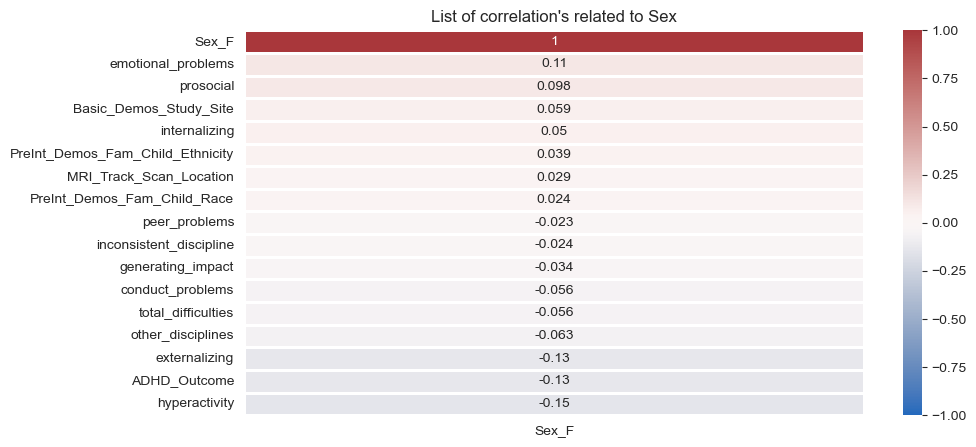

In [321]:
fig, ax = plt.subplots( figsize = (10, 5))
sns.set_style("whitegrid")
heat = sns.heatmap(corr_matrix[["Sex_F"]].sort_values(by='Sex_F', ascending=False), linewidth=1,annot=True, cmap = 'vlag', vmin=-1)
plt.title("List of correlation's related to Sex")
plt.show()

**Observations**


Here we can see that there exists only a tiny bit of correlative power with sex and our categorical variables.


## Peer Feedback

For this project, peers strongly supported the inclusion of social demographic factors and their supporting role in the model. This would keep the main focus on fMRI but still relate to the comprehensive evaluation that is needed for an ADHD diagnosis.

If there were to be gender bias in our model, future iterations could be added to the model. These variables could include regional differences and gender of diagnosing providers to increase accuracy. A peer had mentioned that there have been research studies where the gender of a healthcare provider can influence ADHD diagnosis.


## List of Completed milestones:
  - Defined features in the quantitative metadata dataset and assigned value scales
  - Created correlation matrices(all features and ADHD outcome)
  - Began documentation of feature selection decisions based on correlation

## List of Methods Milestones:
  - Successfully cleaned the dataset and verified scaling
  - Categorical variables were ranked by their impact one the model.
  - Data exploring via observing histograms, pairplots, basic statistics and correlation matrices.
  - Preliminary Model construction via kNN, Decision tree, SVM.


## Summary

<p> &nbsp&nbsp&nbsp We have done considerable work in exploring our datasets and deducing important features to include in a final model. We have used multiple methods to deduce feature usability including correlation matrices, histogram plots, pair-plot graph and actually implementing processed features in to models to evaluate their utility. </p>

<p> &nbsp&nbsp&nbsp Looking forward towards our final analysis, what we want to add and improve on will be increased depth to our exploration and processing via PCA and clustering and improved feature engineering. On top of that, we will think about how we will be combing and combining data for final analysis. Lastly, we will need to begin injeciting data into models. We are leaning towards ensemble methods such as Random Forest, as well as SVM, and Artificial Neural Networks. We will also considering  building an algorithm to tune each potential model to it best fitting parameters. </p>

## Project Schedule

**First Milestone Mar 28 (TODAY)**
<br>
<br>

**END OF WEEK (30th)** Have a good idea what models we might consider building.
<br>
<br>


**Week 4: March 31st - April 6**
<br>
Model building. Creating code to test models with different parameters via cross validation, etc.
<br>
Deeper exploration and explanation of features being used, and feature processing, scaling
<br>
<br>


**Week 5: April 7th - 13th**
<br>
Finer tuning of our models and features, making sure we have not missed anything.
<br>
Start wrapping up our project by cohering/writing a narrative about our process and our results.
<br>
<br>


**12/13th Start working on a presentation. (Slides?)**
<br>
Need a script
<br>
Begin thinking about when to record our presentation
<br>
<br>


**Final week: week 6: April 14th - 18th**
<br>
Writing about analysis
<br>
Record presentation
(Can reserve a room on campus somewhere.)
<br>
April 18th compose necessary documents and look over everything
<br>
Compose necessary documents to zip and submit. Ideally we would have little to do this day.
<br>
<br>


**Final Project Submission Apr 19 at 12:59am**
<br>
Zip containing Jupyter notebook and supporting documents
<br>
Revised project proposal
<br>
Results of analysis / Limitations of analysis
<br>
Presentation/Screencast video Submission
<br>
Strictly 3 minutes, walking through the project.
<br>
“What do you feel is the best part of your project? What insights did you gain? What is the single most important thing you would like your audience to take away?”
<br>
“Also explain your methods and justify your choices.”


# APPENDIX

## Detailed description of features

### Categorical Metadata


<br>

**Year of enrollment**
<br>

**Basic_Demos_Enroll_Year**

<br>

**Site of phenotypic testing**
<br>
- 1=Staten Island,
- 2=MRV,
- 3=Midtown,
- 4=Harlem,
- 5=SI RUMC
<br>

**Basic_Demos_Study_Site**

<br>

**Ethnicity of child**
<br>
- 0= Not Hispanic or Latino,
- 1= Hispanic or Latino,
- 2= Decline to specify,
- 3= Unknown
<br>

**PreInt_Demos_Fam_Child_Ethnicity**

<br>

**Race of child**
<br>
- 0= White/Caucasian
- 1= Black/African American
- 2= Hispanic
- 3= Asian
- 4= Indian
- 5= Native American Indian
- 6= American Indian/Alaskan Native
- 7= Native Hawaiian/Other Pacific Islander
- 8= Two or more races
- 9= Other race
- 10= Unknown
- 11=Choose not to specify
<br>

**PreInt_Demos_Fam_Child_Race**

<br>

**Scan location**
<br>
- 1=Staten Island
- 2=RUBIC
- 3=CBIC
- 4=CUNY
<br>

**MRI_Track_Scan_Location**

<br>

**Parent 1 level of education**
<br>
- 3=Less than 7th grade
- 6=Junior high/Middle school (9th grade)
- 9=Partial high school (10th or 11th grade)
- 12=High school graduate
- 15=Partial college (at least one year)
- 18=College education
- 21=Graduate degree
<br>

**Barratt_Barratt_P1_Edu**

<br>

**Parent 1 occupation**
<br>
- 0=Homemaker, stay at home parent.
- 5=Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.
- 10=Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.
- 15=Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.
- 20=Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.
- 25=Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.
- 30=Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.
- 35=Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.
- 40=Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.
- 45=Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.
<br>

**Barratt_Barratt_P1_Occ**

<br>

**Parent 2 level of education**
<br>

**Barratt_Barratt_P2_Edu**

<br>

**Parent 2 occupation**
<br>

**Barratt_Barratt_P2_Occ**

### Qunatative Metadata

**participant_id -- UmrK0vMLopoR**
- PHI removed identifier.

<br>

**Edinburgh Handedness Questionnaire**
<br>

**EHQ_EHQ_Total -- 40.0**
<br>
EHQ > 40 => Right handed, EHQ < -40 => Left handed, -40<=EHQ<=40 => ambidextrous

<br>

**Ishihara Color Vision Test**
<br>
A higher score indicates normal color vision, while a lower score suggests the presence of a color vision deficiency.
<br>

**ColorVision_CV_Score -- 13**
<br>
<br>

**Alabama Parenting Questionnaire - Parent Report:**
--
"Parent Report assesses parenting practices across dimensions like positive involvement, discipline consistency, and monitoring. Scores typically range based on the frequency of behaviors, with higher scores often indicating more positive practices."
<br>
<br>

**Corporal Punishment Score**
<br>
"Measures the frequency or severity of physical discipline practices"
<br>

**APQ_P_APQ_P_CP -- 3**
<br>
Low freq/rare, 0-10
<br>
Mod/occasional, 11-20
<br>
High/Frequent, 21-30

<br>

**Inconsistent Discipline Score**
<br>
"Evaluates the frequency of inconsistency in applying discipline"
<br>

**APQ_P_APQ_P_ID -- 10**
<br>
Low inconsistency or Consistent discipline, 5-10
<br>
Mod or occasional inconsistency, 11-20
<br>
High or frequent inconsistency, 21-30

<br>

**Involvement Score**
<br>
"Level of positive engagement and interaction between a parent and their child"
<br>

**APQ_P_APQ_P_INV -- 47**
<br>
Low involvement, 10-20
<br>
Mod, 21-40
<br>
High, 41-50

<br>

**Other Discipline Practices Score** (Not factored into total score but provides item level information)
<br>

**APQ_P_APQ_P_OPD ** 13**
<br>
Low use/minimal alternative practices, 5-15
<br>
Mod/Occasional use, 16-25
<br>
High/Frequent, 26-35

<br>

**Poor Monitoring/Supervision Score**
<br>
"Evaluates the extent to which parents fail to adequately monitor or supervise their child's activities"
<br>

**APQ_P_APQ_P_PM -- 11**
<br>
Low/Good supervision, 5-15
<br>
Mod/Occasional lapses, 16-25
<br>
High/Freq lack of supervision, 26-35

<br>

**Positive Parenting Score**
<br>
"Measures the frequency of constructive and supportive parenting practices"
<br>

**APQ_P_APQ_P_PP -- 28**
<br>
Low/min positive reinforcement, 10-20
<br>
Mod/occasional, 21-40
<br>
High/Frequent, 41-50

<br>

**Strength and Difficulties Questionnaire:**
--

**Conduct problems scale**
<br>
"Measures behavioral issues such as temper tantrums, lying, or fighting. Higher scores indicate more frequent conduct problems"
<br>

**SDQ_SDQ_Conduct_Problems -- 0**
<br>
Low/minimal behaviorial issues, 0-3
<br>
Mod,4-6
<br>
High,7-10

<br>

**Total Difficulties Score**
<br>
"A composite measure of emotional symptoms, conduct problems, hyperactivity/inattention, and peer relationship problems. It reflects the overall level of difficulties a child or adolescent may be experiencing. Higher scores indicate greater difficulties. "
<br>

**SDQ_SDQ_Difficulties_Total -- 6**
<br>
Low/Minimal difficulties, 0-13
<br>
Med/Potential concerns, 14-16
<br>
High, 17-40

<br>

**Emotional Problems Scale**
<br>
"Assesses issues such as anxiety, sadness, or fearfulness in children and adolescents. Higher scores reflect greater emotional difficulties."
<br>

**SDQ_SDQ_Emotional_Problems -- 1**
<br>
Low/Minimal emotional issues, 0-4
<br>
Mod/Some concern, 5-6
<br>
Significant emotional difficulties, 7-10

<br>

**Externalizing Score**
<br>
"A combined measure of Conduct Problems and Hyperactivity/Inattention, reflecting outward behaviors like aggression or impulsivity. Higher scores indicate more pronounced externalizing difficulties"
<br>

**SDQ_SDQ_Externalizing -- 5**
<br>
Low/Minimal externalization issues, 0-6
<br>
Some concerns, 7-10
<br>
Significant issues, 11-20

<br>

**Generating Impact Scores**
<br>
"Commonly used to measure the impact of difficulties on daily functioning. It evaluates how emotional and behavioral issues affect aspects like home life, friendships, classroom learning, and hobbies. Higher scores indicate a more significant impact."
<br>

**SDQ_SDQ_Generating_Impact -- 0**
<br>
Minimal effects on functioning, 0-5
<br>
Noticeable challenges, 6-10
<br>
Significant disruptions, 11-20

<br>

**Hyperactivity Scale**
<br>
"Assesses levels of hyperactive and inattentive behaviors, such as restlessness, impulsivity, and difficulty focusing"
<br>

**SDQ_SDQ_Hyperactivity -- 5**
<br>
Minimal hyperactivity, 0-5
<br>
Occasional, 6-7
<br>
Significant difficulties, 8-10

<br>

**Internalizing Score**
<br>
"Combines the subscales for Emotional Problems and Peer Relationship Problems, reflecting inward-directed difficulties such as anxiety, social withdrawal, or sadness. Higher scores suggest more significant internalizing challenges."
<br>

**SDQ_SDQ_Internalizing -- 1**
<br>
Minimal internalization, 0-6
<br>
Some concerns, 7-10
<br>
Internalizing difficulties, 11-20

<br>

**Peer Problems Scale**
<br>
Evaluates challenges in relationships with peers, such as social isolation or difficulties getting along. Higher scores suggest more pronounced issues in social interactions.
<br>

**SDQ_SDQ_Peer_Problems -- 0**
<br>
Minimal peer-related problems, 0-4
<br>
Peer relationships, 5-6
<br>
Difficulties with peers, 7-10

<br>

**Prosocial Scale**
<br>
"Assesses positive social behaviors, such as helping, sharing, and showing kindness to others. Higher scores indicate stronger prosocial tendencies."
<br>

**SDQ_SDQ_Prosocial -- 10**
<br>
Limited prosocial, 0-4
<br>
Occasional, 5-7
<br>
Strong prosocial, 8-10

<br>

**MRI_Track_Age_at_Scan -- NaN**
<br>
Age at time of MRI scan

## References



Centers for Disease Control and Prevention. "Attention-Deficit/Hyperactivity Disorder (ADHD) in Adults." Centers for Disease Control and Prevention, 17 Dec. 2021, www.cdc.gov/adhd/php/adults/index.html.

Kaggle. "WiDS Datathon 2025 Overview." Kaggle, 2025, www.kaggle.com/competitions/widsdatathon2025/overview.

Slobodin, Ortal, and Michael Davidovitch. “Gender Differences in Objective and Subjective Measures of ADHD Among Clinic-Referred Children.” Frontiers in human neuroscience vol. 13 441. 13 Dec. 2019, doi:10.3389/fnhum.2019.00441